In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

### Kernels for $\mathbb{R}^{d}$

In [20]:
# Radial Basis Function (Heat Kernel)
def rbf(x1, x2, params={'lengthScale': 1}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))

# Logistic Gunction
def logistic(z):
    return 1./(1+np.exp(-z))

# Delta Approx.
def delta_approx(x1, x2, params={'lengthScale': .75}):
    d = (x1 - x2)**2 / params['lengthScale']
    return logistic(d) * (1-logistic(d))

### Model

In [21]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})

### MAD Particles

In [22]:
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 10
x = []
for sampleIdx in range(n):
    x.append(q0())

kernel = {'f': delta_approx}
kernel['df'] = grad(kernel['f'])
    
maxEpochs = 100
lr = 2.5
for epochIdx in range(maxEpochs):
    for idx in range(n):
        # model gradient
        update1 = dLogModel(x[idx], params)
        
        # entropy gradient
        update2 = 0.
        z = np.sum([1./n * kernel['f'](x[idx], x_j) for x_j in x])
        
        for x_j in x:
            update2 += 1./n * 1./n * kernel['df'](x[idx], x_j)/(z + 1e-5)
        
        for x_j in x:
            z = np.sum([1./n * kernel['f'](x_j, x_l) for x_l in x])
            update2 += 1./n * 1./n * -kernel['df'](x[idx], x_j)/(z + 1e-5)
        
        # combine
        x[idx] += lr * (update1 - update2)
        
x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

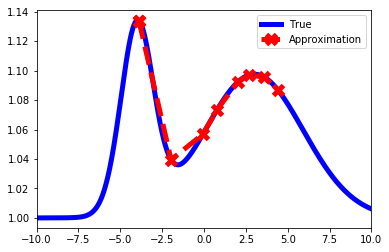

In [23]:
plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")

plt.xlim([-10,10])
plt.legend()
plt.show()

### DP-MAD Particles

In [184]:
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# initial distribution
q0 = np.random.normal

### generate samples
n = 2
x = []
for sampleIdx in range(n):
    x.append(q0() * 10.)

kernel = {'f': delta_approx}
kernel['df'] = grad(kernel['f'])
    
maxEpochs = 100
lr = 5.
alpha = 8.

for epochIdx in range(maxEpochs):
    for idx in range(n):
        # model gradient
        update1 = dLogModel(x[idx], params)
        
        # entropy gradient
        update2 = 0.
        z = np.sum([1./n * kernel['f'](x[idx], x_j) for x_j in x])
        
        for x_j in x:
            update2 += 1./n * 1./n * kernel['df'](x[idx], x_j)/(z + 1e-5)
        
        for x_j in x:
            z = np.sum([1./n * kernel['f'](x_j, x_l) for x_l in x])
            update2 += 1./n * 1./n * -kernel['df'](x[idx], x_j)/(z + 1e-5)
        
        # combine
        x[idx] += lr * (update1 - update2)
        
    if (epochIdx+1)%10 == 0:
        # compute free entergy
        f = np.zeros((n,))
        for idx in range(n):
            f[idx] = np.exp(logModel(x[idx], params) - np.log(np.sum([1./n * kernel['f'](x[idx], x_l) for x_l in x])))
        
        # get probe particle
        probe_idx = np.argmin(f)
        
        z = np.sum(f) - f[probe_idx]
        if alpha/(z+alpha) < f[probe_idx]/(z+alpha):
            # add particle
            n = n+1
            x = x + [q0() * 10.]
        
        
# compute free entergy
f = np.zeros((n,))
for idx in range(n):
    f[idx] = np.exp(logModel(x[idx], params) - np.log(np.sum([1./n * kernel['f'](x[idx], x_l) for x_l in x])))
        
# get probe particle
probe_idx = np.argmin(f)

# remove probe
x = [v for i,v in enumerate(x) if i != probe_idx]
        
x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

Number of final particles:  11


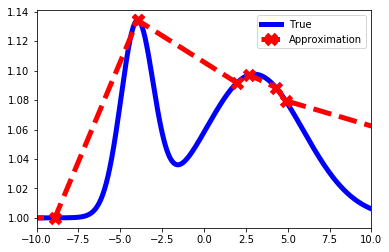

In [185]:
print("Number of final particles: ", n-1)

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")

plt.xlim([-10,10])
plt.legend()
plt.show()